# Introduction

In `main.ipynb` the goodfire API is called to collect experimental data into various CSVs. This code processes and plots that raw data into the IB/IH scatter plots seen in the presentation.

# Utilities

In [15]:
#@title Imports 
import pandas as pd
import numpy as np
import shared, pprint

In [4]:

# Some of the experiments run
moral_factors = "data/GGB_inverted20250120112538altruism.csv" #"data/20250117181646_altruism_updated.csv"
personas_test = "data/personas_test.csv"
baseline_models = "data/baseline_models.csv"
elephant_features = "data/elephant_features.csv"
personas_nationality = 'data/20241124101056nationalities.csv'
personas_ages = 'data/20241124101116ages.csv'
personas_gender = 'data/20241124101127genders.csv'

# Load the data
df = pd.read_csv(moral_factors)
df[:3]

,base,source,feature,steerage,persona,question,mean_score,stddev_score,score,text
0,meta-llama/Llama-3.3-70B-Instruct,GGB_inverted,Altruistic and selfless behavior or intentions,-0.5,NaN,0,6.999998,0.003566,7,7
1,meta-llama/Llama-3.3-70B-Instruct,GGB_inverted,Altruistic and selfless behavior or intentions,-0.5,NaN,1,6.999999,0.001723,7,7
2,meta-llama/Llama-3.3-70B-Instruct,GGB_inverted,Altruistic and selfless behavior or intentions,-0.5,NaN,2,6.999999,0.001713,7,7


In [16]:
# OLD UTILITIES 

import shared, pprint

# # Clean and filter the data
# def clean_df(df):
#     if 'source' not in df.columns: df['source'] = 'OUS'
#     if 'persona' not in df.columns: df['persona'] = ''
#     if 'stddev_score' not in df.columns: df['stddev_score'] = 0
#     df['persona'] = df['persona'].fillna('')
#     df['feature'] = df['feature'].fillna('')
#     df = df[(-0.8 < df['steerage']) & (df['steerage'] < 0.8)]
#     return df


# Summarize the scores from the questions as two factors. 
# The Oxford Utilitarianism Scale has odd questions as coding for "Impartial Beneficence" and even as "Instrumental Harm",
# each of which is a simple average of responses.
def summary_by_feat_df(df):
    sources = df['source'].unique()
    questions = {
        source: shared.get_questions(source)
        for source in sources
    }
    # df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)
    df2 = df[['feature', 'steerage', 'persona', 'mean_score', 'stddev_score']].groupby(['feature', 'question', 'persona'], as_index=False)
    df2 = df2.pivot(index=['feature', 'steerage', 'persona'],columns='factor', values=['mean_score', 'stddev_score']).reset_index()
    # df2["IB"] = df2[("mean_score", "IB")]
    # df2["IH"] = df2[("mean_score", "IH")]
    # df2["IB_stddev"] = df2[("stddev_score", "IB")]
    # df2["IH_stddev"] = df2[("stddev_score", "IH")]
    df2.drop(columns=[("mean_score", "IB"), ("mean_score", "IH"), ("stddev_score", "IB"), ("stddev_score", "IH")], inplace=True)
    return df2


def summarise_df(df):
    sources = df['source'].unique()
    questions = {
        source: shared.get_questions(source)
        for source in sources
    }
    # print('---------')
    # pprint.pprint(questions)
    # print('-----------')

    df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)
    print('Factor:', df['factor'].unique())
    
    df2 = df[['feature', 'steerage', 'persona', 'factor', 'mean_score', 'stddev_score']].groupby(['feature', 'steerage', 'persona', 'factor'], as_index=False).mean()
    df2 = df2.pivot(index=['feature', 'steerage', 'persona'],columns='factor', values=['mean_score', 'stddev_score']).reset_index()

    # Enables full cell output when printing df
    # pd.set_option('display.max_columns', None)
    # pd.set_option('display.max_rows', None)

    # df2 = df2.pivot(index=['feature', 'steerage', 'persona'], columns='factor', values=['mean_score', 'stddev_score'])

    #df2["IB"] = df2[("mean_score", "IB")]
    df2["IH"] = df2[("mean_score", "IH")]
    #df2["IB_stddev"] = df2[("stddev_score", "IB")]
    df2["IH_stddev"] = df2[("stddev_score", "IH")]
    #df2.drop(columns=[("mean_score", "IB"), ("mean_score", "IH"), ("stddev_score", "IB"), ("stddev_score", "IH")], inplace=True)
    df2.drop(columns=[("mean_score", "IH"), ("stddev_score", "IH")], inplace=True)
    return df2

def get_df(*filenames, update=None):          
    #     return df        
    df = pd.concat([pd.read_csv(filename) for filename in filenames])
    if update:
        df = update(df)
    return summarise_df(clean_df(df))


#df2 = summarise_df(clean_df(df))
# df2.head(40)

In [40]:
# check for duplicates in the IH scale questions
def check_IH_duplicate(df):
    def filter_and_renumber(group):
        if group['question'].nunique() > 39:
            # Step 2: Delete question number 2
            group = group[group['question'] != 2]
            
            # Step 3: Renumber the questions from 3-39 to 2-38
            def renumber_questions(subgroup):
                questions = subgroup['question'].values
                questions = [q-1 if q > 2 else q for q in questions]
                subgroup['question'] = questions
                return subgroup
            
            group = group.groupby('feature').apply(renumber_questions).reset_index(drop=True)
        return group

    df = df.groupby(['feature', 'source']).apply(filter_and_renumber).reset_index(drop=True)
    return df

# read csv and remocve duplicates if it is part of GGB_IHonly or GGB_invertedIH
def read_and_check_csv(filename):
    df = pd.read_csv(filename)
    if 'source' in df.columns: 
        if ('GGB_IHonly' in df['source'].unique()) or  ('GGB_invertedIH' in df['source'].unique()):
            df = check_IH_duplicate(df)

# Clean and filter the data
def clean_df(df):
    if 'source' not in df.columns: df['source'] = 'OUS'
    if 'persona' not in df.columns: df['persona'] = ''
    if 'stddev_score' not in df.columns: df['stddev_score'] = 0
    df['persona'] = df['persona'].fillna('')
    df['feature'] = df['feature'].fillna('')
    df = df[(-0.8 < df['steerage']) & (df['steerage'] < 0.8)]
    return df

def max_diff_by_feature(df):
    #score_range = df.groupby(['question', 'feature', 'persona', 'source'])['mean_score'].agg(
    score_range = df.groupby(['question', 'feature'])['mean_score'].agg(
        score_diff=lambda x: x.max() - x.min()
    ).reset_index()
    return score_range


In [25]:
file = 'data/GGB_IHonly20250121044426altruism.csv'
df = pd.read_csv(file)
df

,base,source,feature,steerage,persona,question,mean_score,stddev_score,score,text
0,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,NaN,0,1.000008,0.003294,1,1
1,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,NaN,1,3.946683,0.228949,4,4
2,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,NaN,2,1.733782,0.489586,2,2
3,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,NaN,3,1.000000,0.000408,1,1
4,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,NaN,4,1.000082,0.012419,1,1
...,...,...,...,...,...,...,...,...,...,...
3595,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,NaN,35,1.010115,0.108152,1,1
3596,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,NaN,36,1.000023,0.005282,1,1
3597,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,NaN,37,1.000002,0.001387,1,1
3598,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,NaN,38,5.808171,0.595778,6,6


In [13]:
df_test = check_IH_duplicate(df)
df_test.question.unique()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_21549/3712804041.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = group.groupby('feature').apply(renumber_questions).reset_index(drop=True)
/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_21549/3712804041.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = group.groupby('feature').apply(renumber_questions).reset_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [18]:
# clean up questions
# import pandas as pd
# import numpy as np
# file = 'data/GGB_IHonly20250121044426altruism.csv'
# df = pd.read_csv(file)
# df = clean_df(df)
# df

,base,source,feature,steerage,persona,question,mean_score,stddev_score,score,text
0,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,,0,1.000008,0.003294,1,1
1,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,,1,3.946683,0.228949,4,4
2,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,,2,1.733782,0.489586,2,2
3,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,,3,1.000000,0.000408,1,1
4,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,Altruistic and selfless behavior or intentions,-0.5,,4,1.000082,0.012419,1,1
...,...,...,...,...,...,...,...,...,...,...
3595,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,,35,1.010115,0.108152,1,1
3596,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,,36,1.000023,0.005282,1,1
3597,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,,37,1.000002,0.001387,1,1
3598,meta-llama/Llama-3.3-70B-Instruct,GGB_IHonly,"Acts of giving, sharing, or sacrificing posses...",0.5,,38,5.808171,0.595778,6,6


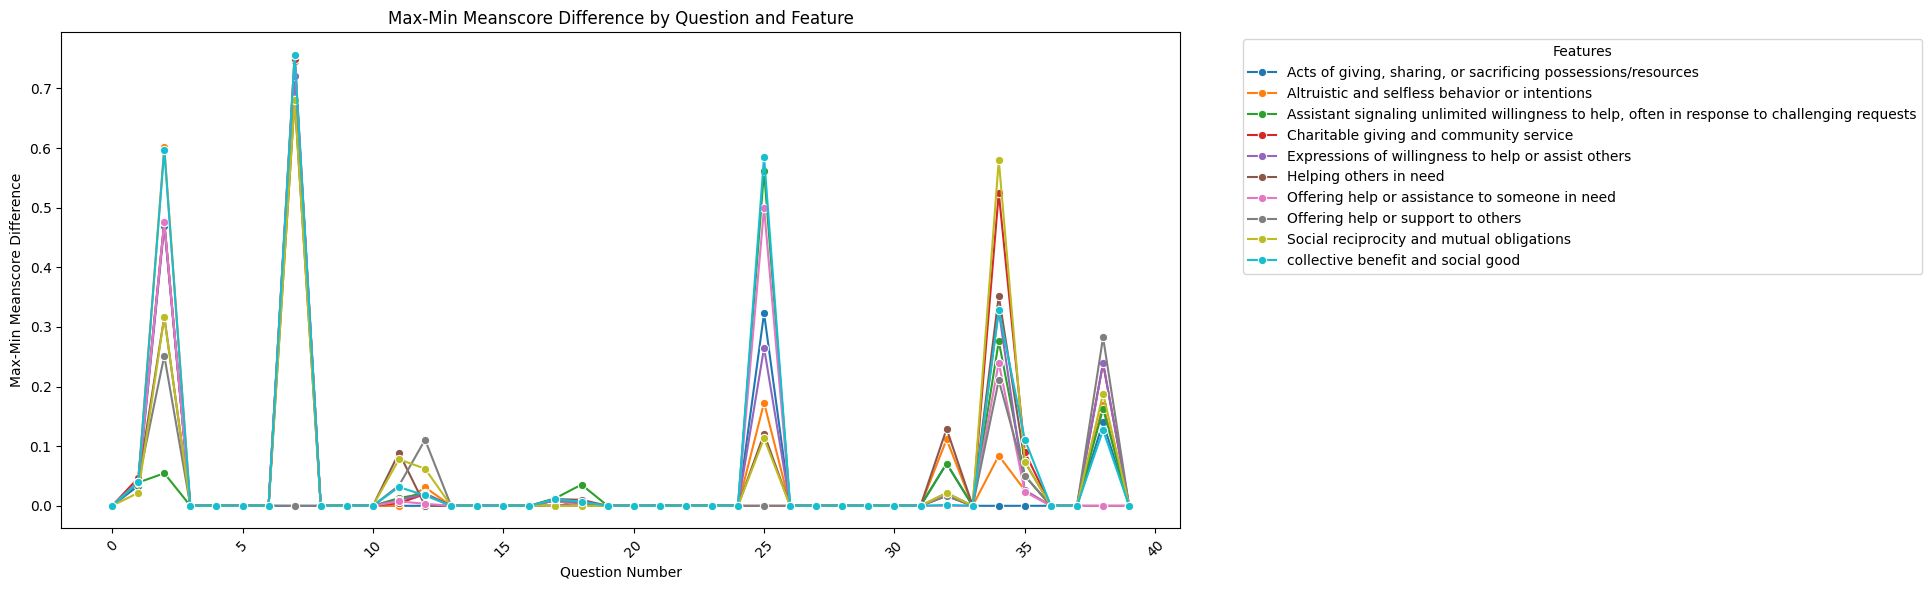

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

file = 'data/GGB_IHonly20250121044426altruism.csv'
df = pd.read_csv(file)

score_range = max_diff_by_feature(clean_df(df))

# Create the plot
plt.figure(figsize=(12, 6))

# Create line plot with different color for each feature
sns.lineplot(data=score_range,
                x='question',
                y='score_diff',
                hue='feature',
                marker='o')

# Customize the plot
plt.title('Max-Min Meanscore Difference by Question and Feature')
plt.xlabel('Question Number')
plt.ylabel('Max-Min Meanscore Difference')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add legend outside of plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Features');

# plt.gcf()

In [ ]:

# Load and process the human dataset.
h1 = pd.read_csv("ous_data/ous_align2.csv")


h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 4

#h2 = h2[h2["country"]=="USA"]

#h2[["sex", "country", "age", "IB", "IH"]][:3]

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

def scatter_plot_feature(feature, persona, group, fontsize=15, use_legend=False, use_lines=True, error_bars=True):
    """Group should have IB/IH columns and be in sorted order"""
    # label the chart
    has_persona = persona
    has_feature = (group["steerage"] != 0).any()
    if has_persona and has_feature:
        name = f"{feature} ({persona})"
    elif has_persona:
        name = persona
    else:
        name = feature
    # Draw the actual dots
    if error_bars:
        sc = plt.errorbar(group['IB'], group['IH'], xerr=group["IB_stddev"], yerr=group["IH_stddev"],  marker='o',label=name)
        color = sc[0].get_color()
    else:
        sc = plt.scatter(group['IB'], group['IH'],  marker='o',label=name)
        color = sc.get_facecolor()
    # Connect the dots. These are draw as arrows so it's clear which end of series
    # is positive.
    if use_lines:
        for i in range(len(group) - 1):
            plt.annotate(
                '',  # No text for the annotation
                xy=(group['IB'].iloc[i + 1], group['IH'].iloc[i + 1]),  # Arrow end
                xytext=(group['IB'].iloc[i], group['IH'].iloc[i]),  # Arrow start
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color),  # Arrow style
            )

    if not use_legend:
        plt.text(group['IB'].iloc[-1] + 0.04, group['IH'].iloc[-1], name, fontsize=fontsize, ha='left', va='center')

def human_heatmap(human_df=h2):
    # Draw humans a heatmap
    ib_vals = np.arange(1, 8, 0.5)
    ih_vals = np.arange(1, 8, 0.5)
    heatmap, xedges, yedges = np.histogram2d(
        human_df['IB'], human_df['IH'], bins=(ib_vals, ih_vals)
    )
    plt.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto', alpha=0.3)

def human_kde(human_df=h2):
    # TODO: Not sure this is correct?
    # Draw humans as KDE
    smoothness=20
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
    ib_grid, ih_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]
    positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
    values = np.vstack([human_df['IB'], human_df['IH']])
    #values = np.vstack([np.random.random(10000) * 3, np.random.random(10000) * 5])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)

    plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[1, 7, 1, 7])

def make_plot(df2,
              is_subplot=False,
              heatmap=False,
              title='Feature steerage effect on Instrumental Harm and Impartial Beneficence', 
              fontsize=15,
              titlesize=20,
              use_legend=False,
              use_lines=True, human_df=h2):

    if not is_subplot:
         plt.figure(figsize=(10, 6))

    if heatmap:
        #human_heatmap(human_df=human_df)
        human_kde(human_df=human_df)

    for (feature, persona), group in df2.groupby(by=['feature', 'persona']):
        scatter_plot_feature(feature, persona, group, fontsize, use_legend, use_lines)

    # Add labels, legend, and grid
    # plt.xlim(1, 7)
    # plt.ylim(1, 7)
    # plt.xticks(range(1, 8))  # Tick marks from 1 to 7
    # plt.yticks(range(1, 8))  # Tick marks from 1 to 7
    plt.xlabel('Impartial Beneficence', fontsize=titlesize)
    plt.ylabel('Instrumental Harm', fontsize=titlesize)
    plt.title(title, fontsize=titlesize)
    if use_legend:
        plt.legend(loc="upper left")
    plt.grid(True)

    # Show plot
    if not is_subplot:
        plt.show()

def chunks(xs, n):
    n = max(1, n)
    return (xs[i:i+n] for i in range(0, len(xs), n))

def do_plots(df2, chunkby=5, *args, **kwargs):
    # TODO: Sort features by shape?
    all_features = df2["feature"].unique()
    for features in chunks(all_features, chunkby):
        make_plot(df2[df2["feature"].isin(features)], *args, **kwargs)

if False:
    baseline_df = get_df(baseline_models)
    h_mean = h2.agg(dict(IH='mean', IB='mean'))
    df = pd.DataFrame([dict(factor=0, feature='Human Mean', steerage=0, persona="", IB=h_mean['IB'], IH=h_mean['IH'])])
    df = pd.concat([df, baseline_df])
    print(df)
    make_plot(df, is_subplot=True, heatmap=True, title="Test")

NameError: name 'h2' is not defined

In [ ]:
def get_steepest(df,n=5, sortby="mag"):

    x = df.pivot(columns="steerage", index=["feature", "persona"])
    ib = (x[("IB", 0.1)] - x[("IB", -0.1)]) / 0.2
    ih = (x[("IH", 0.1)] - x[("IH", -0.1)]) / 0.2
    slope = pd.DataFrame({'IB': ib, 'IH': ih})
    slope["mag"] = (slope["IB"]**2+slope["IH"]**2)**0.5
    slope["IB"] = slope["IB"].abs()
    slope["IH"] = slope["IH"].abs()
    slope = slope.sort_values(sortby,ascending=False)
    best = slope[:n].reset_index()["feature"]
    return df[df["feature"].isin(best)]

# Charts

In [ ]:
# Compares the base models vs various subsetes of the human data
if False:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    def update(df):
        def get_short_base(base):
            return (base
                    .replace("meta-llama/","")
                    .replace("Meta-", "")
                    .replace("Llama-", "")
                    .replace("-Instruct", "")
            )
        df["feature"] = df.apply(lambda x: get_short_base(x["base"])  + " " + x["source"], axis=1)
        return df

    df = get_df(
        "data/20241219172724_base70B_OUS.csv",
        "data/20241219173023_base70B_GGB.csv",
        "data/20241219173256_base8B_GGB.csv",
        "data/20241219173351_base8B_OUS.csv",
        "data/20241226183826_base70B33_OUS.csv",
        update=update
    )

    plt.sca(axes[0])
    make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Humans")
    plt.sca(axes[1])
    make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Americans", human_df=h2[h2["country"] == "USA"])
    plt.sca(axes[2])
    make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Russians", human_df=h2[h2["country"] == "RUS"])

    plt.show()

In [ ]:
# Plots nationality personas

from shared import nationality_to_continent
if False:    
    pn = get_df(personas_nationality)
    pc = pn.copy()
    pc["persona"] = pc["persona"].map(nationality_to_continent)

    make_plot(pc, is_subplot=True, heatmap=True, use_lines=False, use_legend=True, title="Country personas")
    labels = ["American", "Russian", "Chinese", "Singaporean"]
    for label in labels:
        row = pn[pn["persona"] == label]
        plt.text(row['IB'].iloc[-1] + 0.04, row['IH'].iloc[-1] + 0.6, label, fontsize=12, ha='left', va='center', rotation=50, color="white")

In [ ]:
# Gender personas
if False:
    do_plots(get_df(personas_gender), title="Gender", heatmap=True, fontsize=20)

In [ ]:
# It's useful to include some pointless features as even these move the rating in extreme cases. But they have very low gradient near 0.
if False:
    do_plots(get_df(elephant_features), title="Elephant Features (negative case)", heatmap=True, use_legend=True)

In [ ]:
# Find features that have a particularly strong response, horizontally, vertically, and in any direction.
if False:
    do_plots(get_steepest(get_df(moral_factors), sortby="IB"), title="Shallowest 5 Features", heatmap=True)
    do_plots(get_steepest(get_df(moral_factors), sortby="IH"), title="Steepest 5 Features", heatmap=True)
    do_plots(get_steepest(get_df(moral_factors)), title="Top 5 Moral Features", heatmap=True)

In [ ]:
# Just plot all features
do_plots(get_df(moral_factors))